# Final Year Project - Times of Malta Image Analysis Section

## Overview

In this section, the images created using the Emoji Inset Creator notebook are used to train a binary classifier model to differentiate between an image with an emoji and an image without one.

## Installing / Importing Packages

The following packages are required for the notebook to work.

In [1]:
#Importing necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import pandas as pd
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import sys

In [2]:
# imagePaths = ['TestI', 'Test Images/EmojiImagesOne']

In [3]:
# #Setting Counters
# insetCounter = 0
# notInsetCounter = 0

# #For each path
# for imagePath in imagePaths:

#     #For each image and its corresponding Inset attribute value in the csv file
#     for image in glob.glob(imagePath + "/*"):
        
#         #Open the image
#         image = Image.open(image)

#         #If it is Inset
#         if imagePath == 'COCODataset/validation/data':
#             #Save the image in the inset folder
#             image.save('.\\Emoji_Classification\\notinset\\Image'+str(insetCounter)+".jpg")
#             insetCounter = insetCounter + 1
#         else:
#             #Save the image in the notinset folder
#             image.save('.\\Emoji_Classification\\inset\\Image'+str(notInsetCounter)+".jpg")
#             notInsetCounter = notInsetCounter + 1

## Setting up Parameters

Setting parameter values to be used when training the model.

In [4]:
#Setting parameters to be used
batchSize = 32
imageHeight = 180
imageWidth = 180

#Path from where to retrieve images
dataDirectory = ".\\Testing_Classification\\train"

## Creating Testing Set

In [5]:
def cut_and_move_images(source_folder, destination_folder, percentage_to_cut):
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get a list of all files in the source folder
    all_files = os.listdir(source_folder)

    # Calculate the number of files to cut
    num_files_to_cut = int(len(all_files) * percentage_to_cut)

    # Randomly select files to cut
    files_to_cut = random.sample(all_files, num_files_to_cut)

    # Move selected files to the destination folder
    for file_name in files_to_cut:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.move(source_path, destination_path)


percentage_to_cut = 0.2  # 20%

cut_and_move_images("./Testing_Classification/train/inset", "./Testing_Classification/test/inset", percentage_to_cut)
cut_and_move_images("./Testing_Classification/train/notInset", "./Testing_Classification/test/notInset", percentage_to_cut)

## Splitting Images into Training Set and Validation Set

Using the image_dataset_from_directory() function provided by Tensorflow, the training set and validation set are created and saved into their respective variables.

In [6]:
# testingSet = tf.keras.utils.image_dataset_from_directory(
#     testingDirectory,
#     seed=123,
#     image_size=(imageHeight, imageWidth),
#     batch_size=batchSize
# )

In [7]:
#Getting Training Set
trainingSet = tf.keras.utils.image_dataset_from_directory(
  dataDirectory,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (imageHeight, imageWidth),
  batch_size = batchSize)

Found 4800 files belonging to 2 classes.
Using 3840 files for training.


In [8]:
#Getting Validation Set
validationSet = tf.keras.utils.image_dataset_from_directory(
  dataDirectory,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (imageHeight, imageWidth),
  batch_size = batchSize)

Found 4800 files belonging to 2 classes.
Using 960 files for validation.


## Displaying Class Names

The class names found are displayed to the user.

In [9]:
#Retrieving Class Names and displaying them
classNames = trainingSet.class_names
print(classNames)

['inset', 'notInset']


## Configuring Dataset for Performance Issues

The dataset is cached to improve performance.

In [10]:
#Configuring Dataset and caching it
AUTOTUNE = tf.data.AUTOTUNE

trainingSet = trainingSet.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=AUTOTUNE)

## Normalising Data

The Training Set RGB channel values are normalised from [0, 255] to [0, 1].

In [11]:
#Normalising the data
normalisationLayer = layers.Rescaling(1./255)
normalisedSet = trainingSet.map(lambda x, y: (normalisationLayer(x), y))
imageBatch, labelsBatch = next(iter(normalisedSet))
firstImage = imageBatch[0]

## Creating the Model

The Keras Sequential model includes three convolution blocks, each followed by a max pooling layer. On top, there's a fully-connected layer with 128 units activated by ReLU.

In [12]:
#Getting number of classes
numberOfClasses = len(classNames)

#Creating Keras Sequential Model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(imageHeight, imageWidth, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numberOfClasses)
])

## Compiling the Model

The compile function is called on the model.

In [13]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

Displaying a summary of the model.

In [14]:
#Displaying Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model

The model is now trained for a number of epochs using the training set. The validation set is also used to calculated the accuracy and loss.

In [15]:
#Setting number of epochs to occur
epochs = 15

#Training the Model
history = model.fit(
  trainingSet,
  validation_data = validationSet,
  epochs = epochs
)

Epoch 1/15
120/120 [==============================] - 59s 467ms/step - loss: 0.5465 - accuracy: 0.7495 - val_loss: 0.5045 - val_accuracy: 0.7375
Epoch 2/15
120/120 [==============================] - 60s 504ms/step - loss: 0.4216 - accuracy: 0.8143 - val_loss: 0.3464 - val_accuracy: 0.8802
Epoch 3/15
120/120 [==============================] - 51s 424ms/step - loss: 0.2560 - accuracy: 0.9055 - val_loss: 0.1975 - val_accuracy: 0.9198
Epoch 4/15
120/120 [==============================] - 51s 426ms/step - loss: 0.1709 - accuracy: 0.9398 - val_loss: 0.1879 - val_accuracy: 0.9427
Epoch 5/15
120/120 [==============================] - 44s 366ms/step - loss: 0.1177 - accuracy: 0.9542 - val_loss: 0.1427 - val_accuracy: 0.9427
Epoch 6/15
120/120 [==============================] - 47s 394ms/step - loss: 0.0763 - accuracy: 0.9688 - val_loss: 0.1428 - val_accuracy: 0.9531
Epoch 7/15
120/120 [==============================] - 48s 402ms/step - loss: 0.0725 - accuracy: 0.9750 - val_loss: 0.1733 - val_ac

## Displaying Accuracy and Loss Graphs

The Training and Validation Graphs are displayed showing the change in accuracy and loss over each epoch.

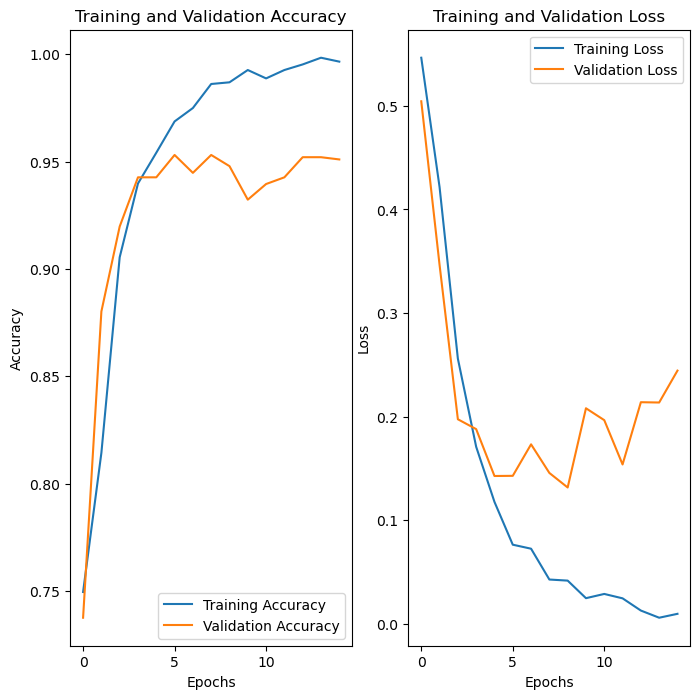

In [16]:
#Retrieving accuracy and loss of both the training set and validation set
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
loss = history.history['loss']
validationLoss = history.history['val_loss']

#Retrieving the range of epochs
epochsRange = range(epochs)

#Plotting the Graphs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

In [17]:
#Getting Training Set
testSet = tf.keras.utils.image_dataset_from_directory(
  "./Testing_Classification/test",
  seed = 123,
  image_size = (imageHeight, imageWidth),
  batch_size = batchSize)

Found 1200 files belonging to 2 classes.


In [18]:
predictions = model.predict(testSet)

38/38 [==============================] - 4s 86ms/step


In [19]:
prediction_classes_class = [
    'Inset' if prob[0] > prob[1] else 'NotInset' for prob in predictions
]
# convert prediction probabilities to binary predictions
prediction_classes = [
    1 if prob[0] > prob[1] else 0 for prob in predictions
]

prediction_classes

[1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


In [20]:
testingNegatives = []
testingPositives = []

def testing_images(directory, class_name, target_list):
    for image in os.listdir(directory):
        img = tf.keras.utils.load_img(
            os.path.join(directory, image), target_size=(imageHeight, imageWidth)
        )

        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        if classNames[np.argmax(score)] == class_name:
            target_list.append(1)
        else:
            target_list.append(0)


# Process NormalImages
testing_images("Testing_Classification/test/notinset", "notinset", testingNegatives)

# Process OneEmojiImages
testing_images("Testing_Classification/test/inset", "inset", testingPositives)


1/1 [==============================] - 0s 24ms/step


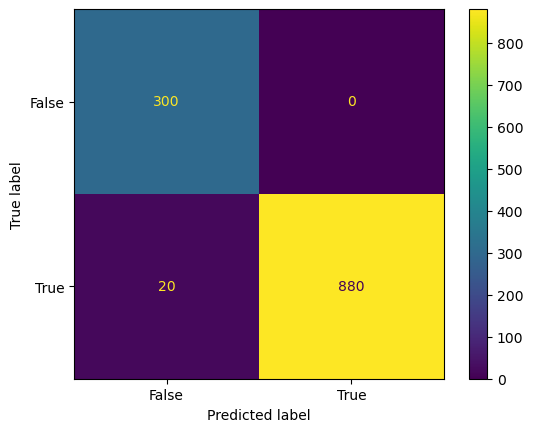


Evaluation Metrics:
Precision: 1.0000
Recall: 0.9375
F1-Measure: 0.9677


In [21]:
actual = np.concatenate((len(os.listdir("Testing_Classification/test/notinset")) * [0], len(os.listdir("Testing_Classification/test/inset")) * [1]))
predicted = testingNegatives + testingPositives

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

cm_display.plot()
plt.show()

TP, FP, FN, TN = confusion_matrix.ravel()

precision = TP / (TP + FP) 
recall = TP / (TP + FN) 
f1_measure = 2 * (precision * recall) / (precision + recall)

print("\n\033[1mEvaluation Metrics:\033[0m")
print("\033[1mPrecision:\033[0m {:.4f}".format(precision))
print("\033[1mRecall:\033[0m {:.4f}".format(recall))
print("\033[1mF1-Measure:\033[0m {:.4f}".format(f1_measure))

# Moving Test Set Back to Folder

In [22]:
import os
import shutil

# Define the paths to the source and destination folders
testset_path = "./Testing_Classification/test/"
normal_images_path = "./Testing_Classification/train/notInset/"
one_emoji_images_path = "./Testing_Classification/train/inset/"

# Loop through the subfolders in the TestSet folder
for subfolder in os.listdir(testset_path):
    subfolder_path = os.path.join(testset_path, subfolder)
    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop through the files in the subfolder
        for filename in os.listdir(subfolder_path):
            # Check if the file is an image file
            if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                # Check if the subfolder is OneEmojiImages
                if subfolder == "inset":
                    # Move the file to the OneEmojiImages folder
                    shutil.move(os.path.join(subfolder_path, filename), os.path.join(one_emoji_images_path, filename))
                else:
                    # Move the file to the NormalImages folder
                    shutil.move(os.path.join(subfolder_path, filename), os.path.join(normal_images_path, filename))
